# FAERS AE Multilabel Outcomes ML pipeline - Dask Distributed + Joblib

## Methodology

### Objective
**Use FAERS data on drug safety to identify possible risk factors associated with patient mortality and other serious adverse events associated with approved used of a drug or drug class** 

### Data
**_Outcome table_** 
1. Start with outcome_c table to define unit of analysis (primaryid)
2. Reshape outcome_c to one row per primaryid
3. Outcomes grouped into 3 categories: a. death, b. serious, c. other  
4. Multiclass model target format: each outcome grp coded into separate columns

**_Demo table_**
1. Drop fields not used in model input to reduce table size (preferably before import to notebook)
2. Check if demo table one row per primaryid (if NOT then need to reshape / clean - TBD)

**_Model input and targets_**
1. Merge clean demo table with reshaped multilabel outcome targets (rows: primaryid, cols: outcome grps)
2. Inspect merged file to check for anomalies (outliers, bad data, ...)

### Model
**_Multilabel Classifier_**
1. Since each primaryid has multiple outcomes coded in the outcome_c table, the ML model should predict the probability of each possible outcome.
2. In scikit-learn lib most/all classifiers can predict multilabel outcomes by coding target outputs into array

### Results
TBD

### Insights
TBD

In [1]:
# scale sklearn dask example setup - compare to multi thread below
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:36785 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.00 GB


In [2]:
#import libraries
import numpy as np
print('The numpy version is {}.'.format(np.__version__))
import pandas as pd
print('The pandas version is {}.'.format(pd.__version__))
from pandas import read_csv, DataFrame
#from random import random

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

# preprocess + model selection + pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler  #, LabelBinarizer, MultiLabelBinarizer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.model_selection import train_test_split  #, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  #, make_pipeline
from sklearn.multioutput import MultiOutputClassifier

# models supporting multilabel classification
#from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
#from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV

# metrics appropriate for multilabel classification
from sklearn.metrics import jaccard_score, hamming_loss, accuracy_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

# feature importance
from sklearn.inspection import permutation_importance, partial_dependence

# visualization
import matplotlib as mpl
print('The matplotlib version is {}.'.format(mpl.__version__))
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
print('The seaborn version is {}.'.format(sns.__version__))
sns.set()

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The numpy version is 1.19.5.
The pandas version is 1.2.0.
The scikit-learn version is 0.24.0.
The matplotlib version is 3.0.2.
The seaborn version is 0.9.0.


In [3]:
# read data into pandas to check
infile = '../input/demo-outc_cod-multilabel-wt_lbs-age_yrs.csv'
cols_in = ['primaryid', 'i_f_code', 'rept_cod', 'sex', 'occp_cod', 'outc_cod__CA', 
           'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 'outc_cod__OT', 
           'outc_cod__RI', 'n_outc', 'wt_lbs', 'age_yrs']

df = pd.read_csv(infile, usecols=cols_in)  # integrate dask dataframes later
print(df.columns, '\n')
print(df.head(),'\n')
print(f'Total number of rows: {len(df):,}\n')
print(f'Unique number of primaryids: {df.primaryid.nunique():,}')

Index(['primaryid', 'i_f_code', 'rept_cod', 'sex', 'occp_cod', 'outc_cod__CA',
       'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT',
       'outc_cod__OT', 'outc_cod__RI', 'n_outc', 'wt_lbs', 'age_yrs'],
      dtype='object') 

   primaryid i_f_code rept_cod sex occp_cod  outc_cod__CA  outc_cod__DE  \
0  100046942        F      EXP   F       LW             0             0   
1  100048206        F      EXP   F       MD             0             0   
2  100048622        F      EXP   F       LW             0             0   
3  100051352        F      EXP   F       LW             0             0   
4  100051382        F      EXP   F       LW             0             0   

   outc_cod__DS  outc_cod__HO  outc_cod__LT  outc_cod__OT  outc_cod__RI  \
0             0             0             0             1             0   
1             0             1             0             1             0   
2             0             0             0             1             0   
3   

## ML Pipeline

In [ ]:
# load df into X, y arrays
#print(len(df), df.columns, df.head())

In [4]:
# remove fields not in model to reduce memory load
y_drop = ['primaryid', 'i_f_code', 'rept_cod', 'sex', 'occp_cod', 'n_outc', 'wt_lbs', 'age_yrs']
          
X_drop = ['primaryid', 'outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 
          'outc_cod__LT', 'outc_cod__OT', 'outc_cod__RI']
          
# convert target to ndarray for sklearn
y = df.drop(y_drop, axis=1)
y_arr = y.to_numpy()
X = df.drop(X_drop, axis=1)

print('y_arr\n', y_arr.shape, '\n', y_arr.dtype, '\n', y_arr[:2])
print('X\n', X.shape, '\n', X.dtypes, '\n', X[:2])

y_arr
 (260715, 7) 
 int64 
 [[0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0]]
X
 (260715, 7) 
 i_f_code     object
rept_cod     object
sex          object
occp_cod     object
n_outc        int64
wt_lbs      float64
age_yrs     float64
dtype: object 
   i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
0        F      EXP   F       LW       1  178.574463      NaN
1        F      EXP   F       MD       2         NaN     68.0


In [5]:
# Training, test set split (can extend later to multiple train-test splits in pipeline)
X_train, X_test, y_train, y_test = train_test_split(X, y_arr, test_size = 0.3)

print('X_train\n', X_train.shape, '\n', X_train[:2])
print('y_train\n', y_train.shape, '\n', y_train[:2])
print('X_test\n', X_test.shape, '\n', X_test[:2])
print('y_test\n', y_test.shape, '\n', y_test[:2])

X_train
 (182500, 7) 
        i_f_code rept_cod sex occp_cod  n_outc      wt_lbs  age_yrs
4570          F      EXP   M       HP       2         NaN     70.0
214019        I      EXP   M       HP       1  276.129031     21.0
y_train
 (182500, 7) 
 [[0 0 0 1 0 1 0]
 [0 0 0 1 0 0 0]]
X_test
 (78215, 7) 
        i_f_code rept_cod sex occp_cod  n_outc     wt_lbs  age_yrs
74111         I      EXP   F       HP       1        NaN     93.0
193483        I      EXP   M       MD       1  176.36984     75.0
y_test
 (78215, 7) 
 [[0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]]


In [7]:
# group features by type for categorical vs numeric transformers
num_features = ['n_outc', 'wt_lbs', 'age_yrs']  
cat_features = ['i_f_code', 'rept_cod', 'sex', 'occp_cod']  

print('num_features\n', num_features)
print('cat_features\n', cat_features)

num_features
 ['n_outc', 'wt_lbs', 'age_yrs']
cat_features
 ['i_f_code', 'rept_cod', 'sex', 'occp_cod']


In [8]:
# create transformers for model input features by type
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[
    ('1_hot', OneHotEncoder(handle_unknown='ignore'))])

#columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')

In [9]:
# combine transformers into preprocessing step
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)], remainder='passthrough') # *** MUST INCL REMAINDER=PASSTHROUGH OR ERR!

#print(dir(preprocessor._transformers.__dir__.__name__))  #, '\n', preprocessor.named_transformers_)

In [10]:
# multioutput classifier using pipeline
ridgecv = RidgeClassifierCV()
ml_ridgecv = MultiOutputClassifier(ridgecv)  #, njobs=-1)

ml_ridgecv_pl = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', ml_ridgecv)])

In [11]:
'''joblib as dask parallel backend (simple multicore setup above - 1 worker per CPU core,
1 process (thread) per worker) - no special programming needed''' 

import joblib

with joblib.parallel_backend('dask'):
    ml_ridgecv_pl.fit(X_train, y_train)

In [15]:
# multilabel test set prediction Y ~ [samples, outcomes] matrix
y_pred = ml_ridgecv_pl.predict(X_test) 

# accuracy, hamming loss and jaccard score for mlabel
print('accuracy: ', accuracy_score(y_test, y_pred))
print('hamming loss: ', hamming_loss(y_test, y_pred))
print('jaccard score: ', jaccard_score(y_test, y_pred, average='micro'))

accuracy:  0.5247331074602058
hamming loss:  0.11820531319348682
jaccard score:  0.4940388238697219


In [26]:
# generate ml cm
multilabel_cm = multilabel_confusion_matrix(y_test, y_pred)
print(multilabel_cm.shape, '\n', multilabel_cm)

(7, 2, 2) 
 [[[77733     0]
  [  482     0]]

 [[65568   669]
  [10947  1031]]

 [[76134     0]
  [ 2081     0]]

 [[41958  4385]
  [17064 14808]]

 [[74398     3]
  [ 3633   181]]

 [[ 5683 22014]
  [ 3345 47173]]

 [[78120     0]
  [   95     0]]]


In [33]:
# normalize each 2x2 cm

# step 1 - need sum of each 2x2 cm for each outcome

# reshape from 7x2x2 to 7x4
#cm_7x4 = multilabel_cm.reshape(7,4)
#print(cm_7x4.shape, '\n', cm_7x4)

#multilabel_cm_sum = np.sum(multilabel_cm.reshape(7,4), axis=1)  #confusion_matrix(y_test, y_pred)
#print(multilabel_cm_sum.shape, '\n', multilabel_cm_sum)

(7, 4) 
 [[77733     0   482     0]
 [65568   669 10947  1031]
 [76134     0  2081     0]
 [41958  4385 17064 14808]
 [74398     3  3633   181]
 [ 5683 22014  3345 47173]
 [78120     0    95     0]]
(7,) 
 [78215 78215 78215 78215 78215 78215 78215]


In [46]:
print(len(y_test))

78215


In [47]:
# normalize cm matrix by dividing each element of cm by total num of samples (so much for the linalg above :-)
multilabel_cm_norm = np.divide(multilabel_cm, len(y_test))  #78215)
print(multilabel_cm_norm.shape, '\n', multilabel_cm_norm)

(7, 2, 2) 
 [[[9.93837499e-01 0.00000000e+00]
  [6.16250080e-03 0.00000000e+00]]

 [[8.38304673e-01 8.55334654e-03]
  [1.39960366e-01 1.31816148e-02]]

 [[9.73393850e-01 0.00000000e+00]
  [2.66061497e-02 0.00000000e+00]]

 [[5.36444416e-01 5.60634149e-02]
  [2.18167871e-01 1.89324298e-01]]

 [[9.51198619e-01 3.83558141e-05]
  [4.64488909e-02 2.31413412e-03]]

 [[7.26586972e-02 2.81454964e-01]
  [4.27667327e-02 6.03119606e-01]]

 [[9.98785399e-01 0.00000000e+00]
  [1.21460078e-03 0.00000000e+00]]]


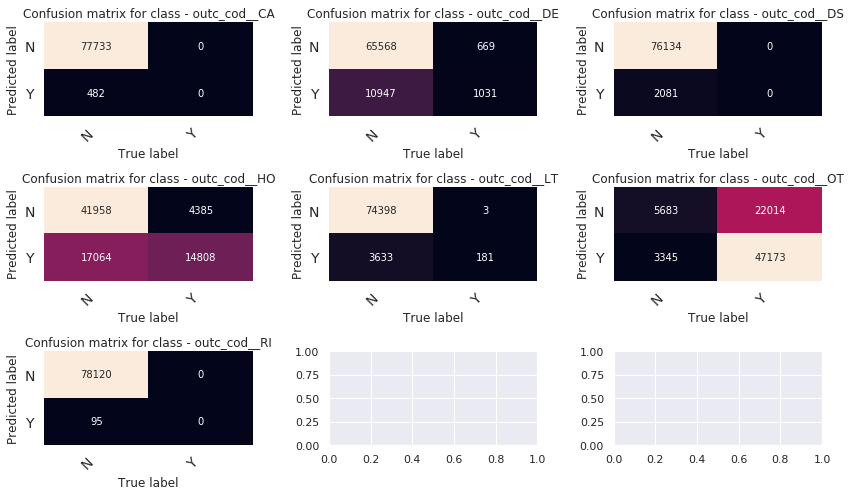

In [49]:
# multilabel confusion matrix - from stack overflow

# 1. create output labels
labels = ['outc_cod__CA', 'outc_cod__DE', 'outc_cod__DS', 'outc_cod__HO', 'outc_cod__LT', 
          'outc_cod__OT', 'outc_cod__RI']

# 2. print cm func using pd, plt, sns libs
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)  #,)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', 
                                 fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', 
                                 fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion matrix for class - " + class_label)


# plot grid of cm's - one per output - raw
fig, ax = plt.subplots(3, 3, figsize=(12, 7))

for axes, cfs_matrix, label in zip(ax.flatten(), multilabel_cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()